In [1]:
# Install Pytorch & other libraries
%pip install "torch==2.4.0" tensorboard pillow

# Install Hugging Face libraries
%pip install  --upgrade \
  "transformers==4.45.1" \
  "datasets==3.0.1" \
  "accelerate==0.34.2" \
  "evaluate==0.4.3" \
  "bitsandbytes==0.44.0" \
  "trl==0.11.1" \
  "peft==0.13.0" \
  "qwen-vl-utils"

  Using cached torch-2.4.0-cp311-cp311-manylinux1_x86_64.whl (797.3 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.4.1
    Uninstalling torch-2.4.1:
      Successfully uninstalled torch-2.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
colpali-engine 0.3.1 requires peft<0.12.0,>=0.11.0, but you have peft 0.13.0 which is incompatible.
colpali-engine 0.3.1 requires pillow<11.0.0,>=9.2.0, but you have pillow 11.0.0 which is incompatible.
torchaudio 2.4.1 requires torch==2.4.1, but you have torch 2.4.0 which is incompatible.
torchvision 0.19.1 requires torch==2.4.1, but you have torch 2.4.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install smolagents

  Using cached torch-2.4.1-cp311-cp311-manylinux1_x86_64.whl (797.1 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.4.0
    Uninstalling torch-2.4.0:
      Successfully uninstalled torch-2.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
colpali-engine 0.3.1 requires peft<0.12.0,>=0.11.0, but you have peft 0.13.0 which is incompatible.
colpali-engine 0.3.1 requires pillow<11.0.0,>=9.2.0, but you have pillow 11.0.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from huggingface_hub import login

login(
  token="YOUR-TOKEN", # ADD YOUR TOKEN HERE
  add_to_git_credential=True
)

In [4]:
prompt = """Create a 150 to 300 words sustainable tourism guide for ##TITLE## and ##QUESTION## based on the image.

##title##: {title}
##question##: {question}"""

system_message = """You are a sustainable tourism expert creating precise 300-word guides for Liechtenstein destinations. Your expertise is showcasing responsible travel experiences while:
- Maintaining exactly 150 to 300 words 
- Focusing on sustainable tourism guide
- Providing specific, actionable details
- Excluding headers, hashtags, or meta-text

Each description must integrate every sustainability aspect while accurately representing the destination."""

In [5]:
from datasets import load_dataset

# Convert dataset to OAI messages       
def format_data(sample):
    return {"messages": [
                {
                    "role": "system",
                    "content": [{"type": "text", "text": system_message}],
                },
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": prompt.format(title=sample["title"], question=sample["question"]),
                        },{
                            "type": "image",
                            "image": sample["image"],
                        }
                    ],
                },
                {
                    "role": "assistant",
                    "content": [{"type": "text", "text": sample["description"]}],
                },
            ],
        }

# Load dataset from the hub
dataset_id = "arad1367/Liechtenstein_Tourist_OCR_Big_Dataset"
dataset = load_dataset("arad1367/Liechtenstein_Tourist_OCR_Big_Dataset", split="train")

# Convert dataset to OAI messages
# need to use list comprehension to keep Pil.Image type, .mape convert image to bytes
dataset = [format_data(sample) for sample in dataset]

print(dataset[345]["messages"])

[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are a sustainable tourism expert creating precise 300-word guides for Liechtenstein destinations. Your expertise is showcasing responsible travel experiences while:\n- Maintaining exactly 150 to 300 words \n- Focusing on sustainable tourism guide\n- Providing specific, actionable details\n- Excluding headers, hashtags, or meta-text\n\nEach description must integrate every sustainability aspect while accurately representing the destination.'}]}, {'role': 'user', 'content': [{'type': 'text', 'text': 'Create a 150 to 300 words sustainable tourism guide for ##TITLE## and ##QUESTION## based on the image.\n\n##title##: Triesenberg\n##question##: What is the name of the tourist destination shown in this image from Liechtenstein?'}, {'type': 'image', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7F51C24126D0>}]}, {'role': 'assistant', 'content': [{'type': 'text', 'text': 'Triesenberg is a charming villag

## Base Model

In [6]:
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig

# Hugging Face model id
model_id = "Qwen/Qwen2-VL-2B-Instruct" 

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    device_map="auto",
    # attn_implementation="flash_attention_2", # not supported for training
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)
processor = AutoProcessor.from_pretrained(model_id)

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
# Preparation for inference
text = processor.apply_chat_template(
    dataset[2]["messages"], tokenize=False, add_generation_prompt=False
)
print(text)

<|im_start|>system
You are a sustainable tourism expert creating precise 300-word guides for Liechtenstein destinations. Your expertise is showcasing responsible travel experiences while:
- Maintaining exactly 150 to 300 words 
- Focusing on sustainable tourism guide
- Providing specific, actionable details
- Excluding headers, hashtags, or meta-text

Each description must integrate every sustainability aspect while accurately representing the destination.<|im_end|>
<|im_start|>user
Create a 150 to 300 words sustainable tourism guide for ##TITLE## and ##QUESTION## based on the image.

##title##: Schellenberg Castle
##question##: What is the name of the tourist destination shown in this image from Liechtenstein?<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant
Schellenberg Castle in Liechtenstein is a historic hilltop castle offering panoramic views. It dates back to the 12th century and is a significant cultural landmark in the region.<|im_end|>



In [10]:
from peft import LoraConfig

# LoRA config based on QLoRA paper & Sebastian Raschka experiment
peft_config = LoraConfig(
        lora_alpha=16,
        lora_dropout=0.05,
        r=8,
        bias="none",
        target_modules=["q_proj", "v_proj"],
        task_type="CAUSAL_LM", 
)

In [109]:
from trl import SFTConfig
from transformers import Qwen2VLProcessor
from qwen_vl_utils import process_vision_info

args = SFTConfig(
    output_dir="Qwen2-VL-2B-Instruct-TRL-sustainable-tourist-FL", # directory to save and repository id
    num_train_epochs=3,                     # number of training epochs
    per_device_train_batch_size=4,          # batch size per device during training
    gradient_accumulation_steps=8,          # number of steps before performing a backward/update pass
    gradient_checkpointing=True,            # use gradient checkpointing to save memory
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=5,                       # log every 10 steps
    save_strategy="epoch",                  # save checkpoint every epoch
    learning_rate=2e-4,                     # learning rate, based on QLoRA paper
    bf16=True,                              # use bfloat16 precision
    tf32=True,                              # use tf32 precision
    max_grad_norm=0.3,                      # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                      # warmup ratio based on QLoRA paper
    lr_scheduler_type="constant",           # use constant learning rate scheduler
    push_to_hub=True,                       # push model to hub
    report_to="tensorboard",                # report metrics to tensorboard
    gradient_checkpointing_kwargs = {"use_reentrant": False}, # use reentrant checkpointing
    dataset_text_field="", # need a dummy field for collator
    dataset_kwargs = {"skip_prepare_dataset": True} # important for collator
)
args.remove_unused_columns=False

# Create a data collator to encode text and image pairs
def collate_fn(examples):
    # Get the texts and images, and apply the chat template
    texts = [processor.apply_chat_template(example["messages"], tokenize=False) for example in examples]
    image_inputs = [process_vision_info(example["messages"])[0] for example in examples]

    # Tokenize the texts and process the images
    batch = processor(text=texts, images=image_inputs, return_tensors="pt", padding=True)

    # The labels are the input_ids, and we mask the padding tokens in the loss computation
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100  #
    # Ignore the image token index in the loss computation (model specific)
    if isinstance(processor, Qwen2VLProcessor):
        image_tokens = [151652,151653,151655]
    else: 
        image_tokens = [processor.tokenizer.convert_tokens_to_ids(processor.image_token)]
    for image_token_id in image_tokens:
        labels[labels == image_token_id] = -100
    batch["labels"] = labels

    return batch

In [110]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset,
    data_collator=collate_fn,
    dataset_text_field="", # needs dummy value
    peft_config=peft_config,
    tokenizer=processor.tokenizer,
)

/home/pejman/pej_envy/lib/python3.11/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/home/pejman/pej_envy/lib/python3.11/site-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/home/pejman/pej_envy/lib/python3.11/site-packages/trl/trainer/sft_trainer.py:321: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/home/pejman/pej_envy/lib/python3.11/site-packages/trl/trainer/sft_trainer.py:396: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might le

In [111]:
# start training, the model will be automatically saved to the hub and the output directory
trainer.train()

# save model 
trainer.save_model(args.output_dir)

/home/pejman/pej_envy/lib/python3.11/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]


Step,Training Loss
5,2.987500
10,2.744200
15,2.437800
20,2.135400
25,1.783100
30,1.372300
35,1.003600
40,0.726800
45,0.522800
50,0.447100


Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}
/home/pejman/pej_envy/lib/python3.11/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}
/home/pejman/pej_envy/lib/python3.11/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}
Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}
Unrecognized keys in

events.out.tfevents.1735321186.joserv2.3936325.6:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

In [ ]:
# free the memory again
del model
del trainer
torch.cuda.empty_cache()

In [7]:
# If error of Cuda
import torch
torch.cuda.empty_cache()

In [15]:
print(f"Memory before inference: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

Memory before inference: 0.00 GB


In [16]:
# Test Model and run Inference 
import torch
from transformers import AutoProcessor, AutoModelForVision2Seq

adapter_path = "./Qwen2-VL-2B-Instruct-TRL-sustainable-tourist-FL"

# Load Model base model
model = AutoModelForVision2Seq.from_pretrained(
  model_id,
  device_map="auto",
  torch_dtype=torch.float16,
  quantization_config=bnb_config # Added
)
processor = AutoProcessor.from_pretrained(model_id)

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from qwen_vl_utils import process_vision_info

# sample from google
sample = {
  "title": "Vaduz Castle",
  "question": "What is the name of the tourist destination shown in this image from Liechtenstein?",
  "image": "VaduzCastle.jpg"
}

# prepare message
messages = [{
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": sample["image"],
            },
            {"type": "text", "text": prompt.format(title=sample["title"], question=sample["question"])},
        ],
    }
]

def generate_description(sample, model, processor):
    messages = [
        {"role": "system", "content": [{"type": "text", "text": system_message}]},
        {"role": "user", "content": [
            {"type": "image","image": sample["image"]},
            {"type": "text", "text": prompt.format(title=sample["title"], question=sample["question"])},
        ]},
    ]
    
        # Preparation for inference
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(model.device)
    # Inference: Generation of the output
    generated_ids = model.generate(**inputs, max_new_tokens=256, top_p=1.0, do_sample=True, temperature=0.8)
    generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text[0]

# let's generate the description
base_description = generate_description(sample, model, processor)
print(base_description)
# you can disable the active adapter if you want to rerun it with
# model.disable_adapters()

In [85]:
model.load_adapter(adapter_path) # load the adapter and activate

ft_description = generate_description(sample, model, processor)
print(ft_description)

Malbun is a ski resort known for its black-graded slopes and panoramic views of the Alps. It features a modern ski lodge and snow-covered mountains.



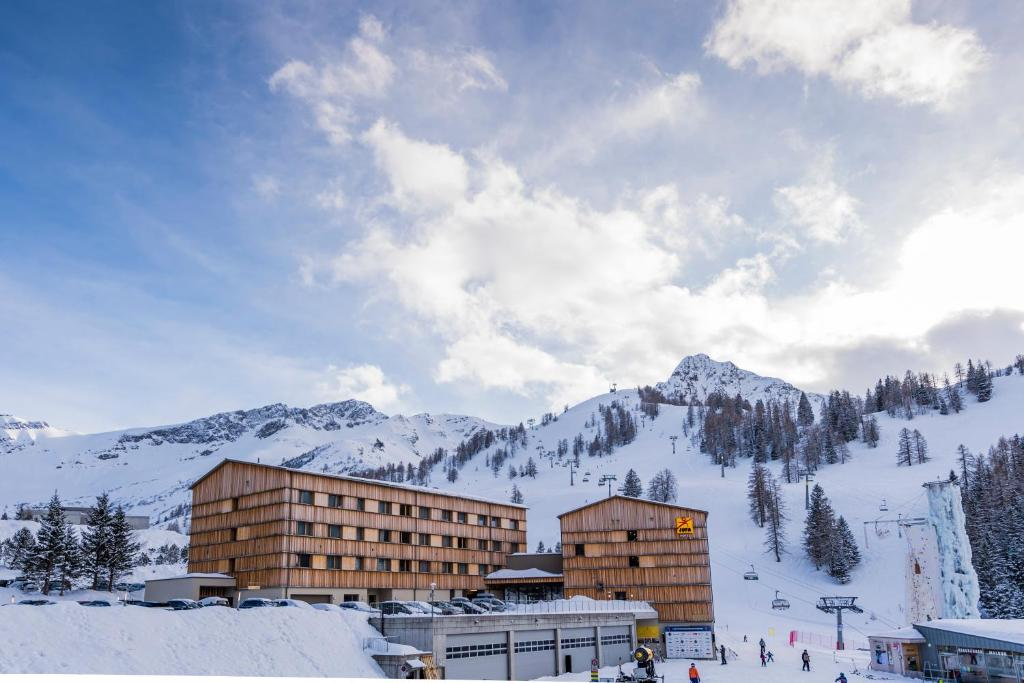

In [90]:
import pandas as pd
from IPython.display import HTML
import base64

def create_stylish_comparison(image_path, base_desc, ft_desc):
   css = """
   <style>
   .container {
       max-width: 800px;            /* reduced from 900px */
       margin: 10px auto;
       font-family: Arial, sans-serif;
       background: #f8f9fa;
       border-radius: 8px;
       box-shadow: 0 2px 10px rgba(0,0,0,0.1);
       padding: 15px;
   }
   .title {
       text-align: center;
       color: #2c3e50;
       font-size: 20px;            /* reduced from 22px */
       margin-bottom: 15px;
   }
   .content-grid {
       display: grid;
       grid-template-columns: 1fr 1.2fr;    /* changed to 2 columns */
       gap: 15px;
   }
   .section {
       background: white;
       padding: 12px;
       border-radius: 6px;
       box-shadow: 0 1px 4px rgba(0,0,0,0.08);
   }
   .model-outputs {
       display: flex;
       flex-direction: column;
       gap: 15px;
   }
   .section-title {
       color: #2c3e50;
       font-size: 16px;
       margin-bottom: 10px;
       padding-bottom: 8px;
       border-bottom: 1px solid #e9ecef;
   }
   img {
       width: 100%;
       border-radius: 6px;
       margin-bottom: 10px;
       max-height: 300px;
       object-fit: cover;
   }
   .description {
       font-size: 13px;
       line-height: 1.4;
       color: #34495e;
       max-height: 200px;          /* reduced from 400px */
       overflow-y: auto;
   }
   </style>
   """

   with open(image_path, "rb") as img_file:
       img_data = base64.b64encode(img_file.read()).decode()

   html = f"""
   {css}
   <div class="container">
       <h1 class="title">Base model & Fine tune model</h1>
       <div class="content-grid">
           <div class="section">
               <h2 class="section-title">Location</h2>
               <img src="data:image/png;base64,{img_data}" alt="Location">
           </div>
           <div class="model-outputs">
               <div class="section">
                   <h2 class="section-title">Base Model</h2>
                   <div class="description">{base_desc}</div>
               </div>
               <div class="section">
                   <h2 class="section-title">Fine-tuned Model</h2>
                   <div class="description">{ft_desc}</div>
               </div>
           </div>
       </div>
   </div>
   """
   return HTML(html)

# Usage
display(create_stylish_comparison("malbun.jpg", base_description, ft_description))

### Make a sustainable Agent based on fine tune model

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Based on this AI-generated sustainable tourism description, generate a Python dictionary with brief,            │
│ mobile-friendly insights:                                                                                       │
│                                                                                                                 │
│     Description: Old Rhine Bridge in Liechtenstein is a historic wooden bridge that crosses the Rhine River. It │
│ was built in 1812 and is a notable landmark surrounded by picturesque mountain scenery.                         │
│                                                                                                                 │
│     Return a dictionary with these exact keys. Each value should be a SINGLE, CONCISE paragraph of 2-3          │
│ sentences maximum:                                                                                              │
│     {                                                                                                           │
│         'transport': "Brief sustainable transport options",                                                     │
│         'culture': "Brief cultural insights",                                                                   │
│         'environment': "Brief environmental guidelines",                                                        │
│         'activities': "Brief sustainable activities"                                                            │
│     }                                                                                                           │
│                                                                                                                 │
│     Requirements:                                                                                               │
│     - Each insight must be exactly 2-3 sentences                                                                │
│     - Focus on the most essential information only                                                              │
│     - Use clear, direct language                                                                                │
│     - Avoid lists or bullet points                                                                              │
│     - Keep each response under 50 words                                                                         │
│     - Only include information directly relevant to this location                                               │
│                                                                                                                 │
╰─ HfApiModel - Qwen/Qwen2.5-Coder-32B-Instruct ──────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 0 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─ Executing this code: ──────────────────────────────────────────────────────────────────────────────────────────╮
│    1 description = "Old Rhine Bridge in Liechtenstein is a historic wooden bridge that crosses the Rhine River. │
│      It was built in 1812 and is a notable landmark surrounded by picturesque mountain scenery."                │
│    2                                                                                                            │
│    3 # Extracting key information                                                                               │
│    4 location = "Old Rhine Bridge in Liechtenstein"                                                             │
│    5 year_built = 1812                                                                                          │
│    6 landscape = "near the Rhine River, surrounded by picturesque mountain scenery"                             │
│    7                                                                                                            │
│    8 # Generating insights                                                                                      │
│    9 transport_insight = "Use public transportation or electric vehicles to minimize environmental impact."     │
│   10 culture_insight = f"Visit the historic Old Rhine Bridge, built in {year_built}, a landmark in              │
│      Liechtenstein."                                                                                            │
│   11 environment_insight = "Explore the mountain scenery responsibly, following local guidelines and leaving no │
│      trace."                                                                                                    │
│   12 activities_insight = "Hike in the mountains and enjoy the river views without disturbing the natural       │
│      surroundings."                                                                                             │
│   13                                                                                                            │
│   14 # Creating the dictionary                                                                                  │
│   15 insights_dict = {                                                                                          │
│   16     'transport': transport_insight,                                                                        │
│   17     'culture': culture_insight,                                                                            │
│   18     'environment': environment_insight,                                                                    │
│   19     'activities': activities_insight                                                                       │
│   20 }                                                                                                          │
│   21                                                                                                            │
│   22 # Printing the dictionary for verification                                                                 │
│   23 print(insights_dict)                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Execution logs:
{'transport': 'Use public transportation or electric vehicles to minimize environmental impact.', 'culture': 'Visit
the historic Old Rhine Bridge, built in 1812, a landmark in Liechtenstein.', 'environment': 'Explore the mountain 
scenery responsibly, following local guidelines and leaving no trace.', 'activities': 'Hike in the mountains and 
enjoy the river views without disturbing the natural surroundings.'}

Out: None

[Step 0: Duration 6.21 seconds| Input tokens: 2,258 | Output tokens: 268]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─ Executing this code: ──────────────────────────────────────────────────────────────────────────────────────────╮
│   1 final_answer(insights_dict)                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Out - Final answer: {'transport': 'Use public transportation or electric vehicles to minimize environmental 
impact.', 'culture': 'Visit the historic Old Rhine Bridge, built in 1812, a landmark in Liechtenstein.', 
'environment': 'Explore the mountain scenery responsibly, following local guidelines and leaving no trace.', 
'activities': 'Hike in the mountains and enjoy the river views without disturbing the natural surroundings.'}

[Step 1: Duration 2.19 seconds| Input tokens: 5,177 | Output tokens: 337]


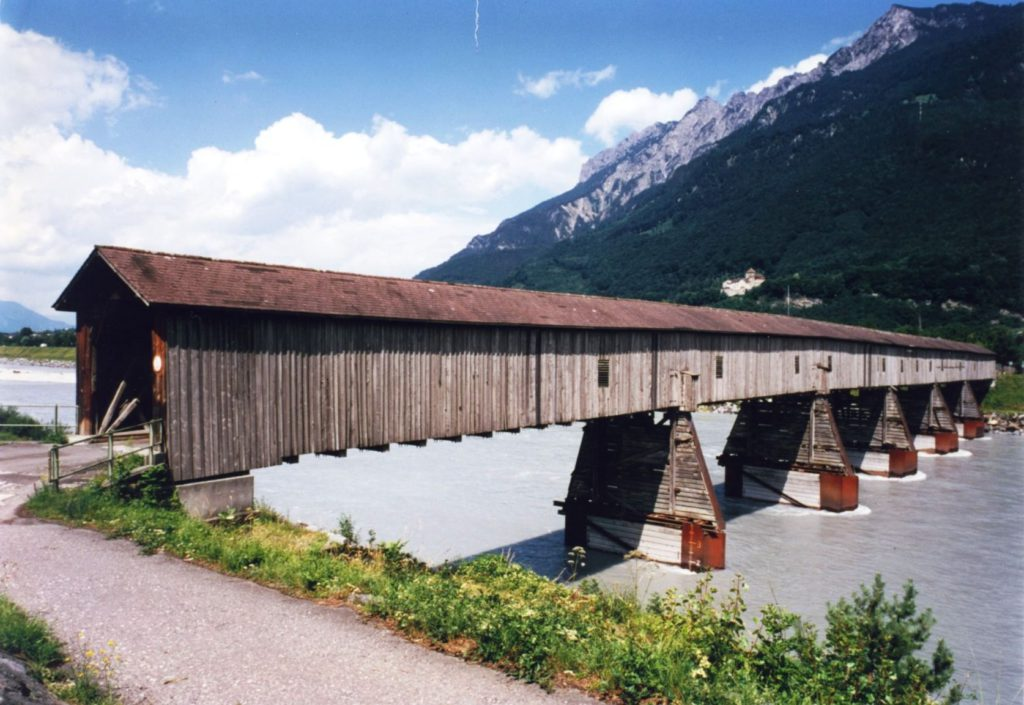

In [78]:
from smolagents import CodeAgent, DuckDuckGoSearchTool, HfApiModel
from qwen_vl_utils import process_vision_info
from IPython.display import HTML
import base64

def get_sustainable_insights(ft_description):
    """
    Use SmalAgent to analyze the fine-tuned model's output and generate sustainable tourism insights
    """
    agent = CodeAgent(tools=[DuckDuckGoSearchTool()], model=HfApiModel())
    
    analysis_prompt = f"""
    Based on this AI-generated sustainable tourism description, generate a Python dictionary with brief, mobile-friendly insights:
    
    Description: {ft_description}
    
    Return a dictionary with these exact keys. Each value should be a SINGLE, CONCISE paragraph of 2-3 sentences maximum:
    {{
        'transport': "Brief sustainable transport options",
        'culture': "Brief cultural insights",
        'environment': "Brief environmental guidelines",
        'activities': "Brief sustainable activities"
    }}
    
    Requirements:
    - Each insight must be exactly 2-3 sentences
    - Focus on the most essential information only
    - Use clear, direct language
    - Avoid lists or bullet points
    - Keep each response under 50 words
    - Only include information directly relevant to this location
    """
    
    raw_insights = agent.run(analysis_prompt)
    
    # Clean up any formatting
    for key in raw_insights:
        if isinstance(raw_insights[key], list):
            raw_insights[key] = ' '.join(raw_insights[key])
        raw_insights[key] = raw_insights[key].strip('"[]')
    
    return raw_insights

def create_sustainable_tourism_analysis(image_path, ft_desc, insights):
    css = """
    <style>
    .container {
        max-width: 1000px;  /* reduced from 1400px */
        margin: 10px auto;  /* reduced from 20px */
        font-family: Arial, sans-serif;
        background: #f8f9fa;
        border-radius: 8px;  /* reduced from 10px */
        box-shadow: 0 2px 10px rgba(0,0,0,0.1);  /* reduced shadow */
        padding: 15px;  /* reduced from 30px */
    }
    .title {
        text-align: center;
        color: #2c3e50;
        font-size: 24px;  /* reduced from 28px */
        margin-bottom: 15px;  /* reduced from 30px */
    }
    .content-grid {
        display: grid;
        grid-template-columns: 1fr 1fr;
        gap: 15px;  /* reduced from 25px */
    }
    .insights-grid {
        display: grid;
        grid-template-columns: 1fr 1fr;
        gap: 10px;  /* reduced from 15px */
        margin-top: 15px;  /* reduced from 25px */
    }
    .section {
        background: white;
        padding: 15px;  /* reduced from 20px */
        border-radius: 6px;  /* reduced from 8px */
        box-shadow: 0 1px 4px rgba(0,0,0,0.08);
    }
    .section-title {
        color: #2c3e50;
        font-size: 16px;  /* reduced from 18px */
        margin-bottom: 10px;  /* reduced from 15px */
        padding-bottom: 8px;  /* reduced from 10px */
        border-bottom: 1px solid #e9ecef;  /* reduced border */
    }
    .insight-card {
        background: #ffffff;
        padding: 12px;  /* reduced from 15px */
        border-radius: 6px;
        border-left: 3px solid #2c3e50;  /* reduced from 4px */
    }
    .insight-title {
        color: #2c3e50;
        font-size: 14px;  /* reduced from 16px */
        font-weight: bold;
        margin-bottom: 8px;  /* reduced from 10px */
    }
    img {
        width: 100%;
        border-radius: 6px;
        margin-bottom: 12px;  /* reduced from 15px */
        max-height: 300px;  /* added max height */
        object-fit: cover;
    }
    .description {
        font-size: 13px;  /* reduced from 15px */
        line-height: 1.4;  /* reduced from 1.6 */
        color: #34495e;
    }
    </style>
    """

    with open(image_path, "rb") as img_file:
        img_data = base64.b64encode(img_file.read()).decode()

    html = f"""
    {css}
    <div class="container">
        <h1 class="title">Smart Sustainable Tourism Agent - Mobile version</h1>
        <div class="content-grid">
            <div class="section">
                <h2 class="section-title">Location View</h2>
                <img src="data:image/png;base64,{img_data}" alt="Location">
            </div>
            <div class="section">
                <h2 class="section-title">Description Based on a Fine-Tuned Sustainable Tourist Model for Liechtenstein</h2>
                <div class="description">{ft_desc}</div>
                
                <div class="insights-grid">
                    <div class="insight-card">
                        <div class="insight-title">🚲 Sustainable Transport</div>
                        <div class="description">{insights['transport']}</div>
                    </div>
                    <div class="insight-card">
                        <div class="insight-title">🏛️ Cultural Guidelines</div>
                        <div class="description">{insights['culture']}</div>
                    </div>
                    <div class="insight-card">
                        <div class="insight-title">🌿 Environmental Tips</div>
                        <div class="description">{insights['environment']}</div>
                    </div>
                    <div class="insight-card">
                        <div class="insight-title">🎯 Sustainable Activities</div>
                        <div class="description">{insights['activities']}</div>
                    </div>
                </div>
            </div>
        </div>
    </div>
    """
    return HTML(html)

def analyze_destination(image_path, model, processor):
    # 1. Generate fine-tuned description
    sample = {
        "title": image_path.split("/")[-1].split(".")[0],
        "question": "Provide a sustainable tourism guide for this destination.",
        "image": image_path
    }
    
    # Get fine-tuned model description
    ft_description = generate_description(sample, model, processor)
    
    # 2. Get agent insights
    insights = get_sustainable_insights(ft_description)
    
    # 3. Display the analysis
    return create_sustainable_tourism_analysis(image_path, ft_description, insights)

# Usage
model.load_adapter(adapter_path)  # Load your fine-tuned model
visualization = analyze_destination("oldRhineBridge.jpg", model, processor)
display(visualization)